In [1]:
#Laos Small Group Project

#This python script models the Laotian power network in 2050 following the Net-Zero Scenario data proposed by the team. The domestic network
#is simplified into 4 regions (North, Central 1, Central 2, South), and generation is distributed along them according to previously identified
#renewable energy potential and land constraints.

#Domestic demand in 2050 is distributed across the 4 regions proportionally to population
#Export demand is based on export commitments to Thailand, Vietnam, China, Myanmar, and Cambodia and following existing infrastructures

#Local voltage levels are at 115kV, while exports to Vietnam and Thailand are at 230kV, with 3 transformers used to upgrade voltage levels

#All input parameters are available in the excel sheet "laos Python Model Inputs" also available in the same GitHub folder

In [2]:
# Import libraries
import geopandas as gpd
import matplotlib.pyplot as plt

import pandas as pd
import pandapower as pp
from pandapower.plotting.plotly import simple_plotly
import pandapower.plotting as plot


In [3]:
# Create network
net = pp.create_empty_network() 


In [4]:
#Read bus data from excel
bus_df= pd.read_excel('ThaiModelInput.xlsx', sheet_name='buses',nrows=4)
#bus_df

In [5]:
# Create buses
b = {}

for i in bus_df['bus_id']:
  b[i] = pp.create_bus(net, vn_kv = bus_df.loc[bus_df['bus_id']==i, 'vn_kv'].values[0], name = bus_df.loc[bus_df['bus_id']==i, 'name'].values[0], geodata = eval(bus_df.loc[bus_df['bus_id']==i, 'geodata'].values[0]),min_vm_pu=0.85)
net.bus

,name,vn_kv,type,zone,in_service,min_vm_pu
0,North,500.0,b,None,True,0.85
1,Northeast,230.0,b,None,True,0.85
2,Bangkok,500.0,b,None,True,0.85
3,South,230.0,b,None,True,0.85


In [6]:
# Create one grid connection point
connect_bus = b[0] 
vm_pu = 1.1

# Create the external grid connection
pp.create_ext_grid(net, bus=connect_bus, vm_pu=vm_pu, name = "Slack bus")

0

In [7]:
# Import line data from excel file-- from_bus, to_bus, length_km, r_ohm_per_km, x_ohm_per_km, c_nf_per_km, max_i_ka
line_df = pd.read_excel('ThaiModelInput.xlsx', sheet_name='lines',nrows=3)
#line_df

In [8]:
# Create lines
for i in line_df.index:
  print(i)
  pp.create_line_from_parameters(net, from_bus=b[line_df.loc[i, 'from_bus']],
                                 to_bus=b[line_df.loc[i, 'to_bus']],
                                 length_km=line_df.loc[i, 'length_km'],
                                 r_ohm_per_km=line_df.loc[i, 'r_ohm_per_km'],
                                 x_ohm_per_km=line_df.loc[i, 'x_ohm_per_km'],
                                 c_nf_per_km=line_df.loc[i, 'c_nf_per_km'],
                                 max_i_ka=line_df.loc[i, 'max_i_ka']
                                 ) 
net.line

0
1
2


,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,None,None,0,2,500.0,0.01,0.01,1.000000e-09,0.0,30.0,1.0,1,None,True
1,None,None,2,1,500.0,0.01,0.01,1.000000e-09,0.0,20.0,1.0,1,None,True
2,None,None,2,3,400.0,0.01,0.01,1.000000e-09,0.0,20.0,1.0,1,None,True


In [9]:
# Import Load data from excel-- geolocation, bus (nearest from geolocation), p_mw

load_df = pd.read_excel('ThaiModelInput.xlsx', sheet_name='loads',nrows=4)
#load_df

In [10]:
# Create loads
p_mw = 'power_p_mw'
q_mvar = 'power_q_mvar'

for i in load_df['bus_id']:
  pp.create_load(net, 
                 b[i], 
                 p_mw=load_df.loc[load_df['bus_id']==i, p_mw].values[0], 
                 q_mvar=load_df.loc[load_df['bus_id']==i, q_mvar].values[0],
                 name=load_df.loc[load_df['bus_id']==i, 'name'].values[0])

In [11]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,North,0,4.4,2.1,0.0,0.0,NaN,1.0,True,wye
1,Northeast,1,6.1,2.9,0.0,0.0,NaN,1.0,True,wye
2,Bangkok,2,4.1,1.9,0.0,0.0,NaN,1.0,True,wye
3,South,3,4.5,2.2,0.0,0.0,NaN,1.0,True,wye


In [12]:
# Generators imported from excel
vm_pu=1.1

gen_df = pd.read_excel('ThaiModelInput.xlsx', sheet_name='gen',nrows=4)
#gen_df    

In [13]:
#Generators
for i in gen_df['gen_id']:
  pp.create_sgen(net, bus=gen_df.loc[gen_df['gen_id']==i, 'bus_id'].values[0],
                 p_mw=gen_df.loc[gen_df['gen_id']==i, 'p_mw'].values[0],vm_pu=1, 
                 name=gen_df.loc[gen_df['gen_id']==i, 'name'].values[0])
net.gen


,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type


In [14]:
#Storage entries are added manually

# pp.create_storage(net,0, p_mw=1348.76, max_e_mwh=25000) #North
# pp.create_storage(net,1, p_mw=4609.91, max_e_mwh=25000) #Central 1
# pp.create_storage(net,2, p_mw=3158.12, max_e_mwh=25000) #Central 2
#pp.create_storage(net,3, p_mw=600, max_e_mwh=25000) #South

In [15]:
# # Create the transformers

# # First Transformer
# #North (115) to Thailand_north (230)
# lv_bus = net.bus[net.bus.name == 'North'].index.values[0]
# hv_bus = net.bus[net.bus.name == 'trafo_b0'].index.values[0]

# # Parameters assumed equal to those of the 100 MVA 220/110 kV standard type
# sn_mva = 400
# vn_hv_kv = 230
# vn_lv_kv = 115
# vk_percent = 12
# vkr_percent = 0.26
# pfe_kw = 3.2
# i0_percent = 0.06
# pp.create_transformer_from_parameters(net, hv_bus=hv_bus, lv_bus=lv_bus, sn_mva=sn_mva, vn_hv_kv=vn_hv_kv, vn_lv_kv=vn_lv_kv, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)

# # Second Transformer
# #Central 1 (115) to Thailand_c1 (230)
# lv_bus = net.bus[net.bus.name == 'Central 1'].index.values[0]
# hv_bus = net.bus[net.bus.name == 'trafo_b1'].index.values[0]


# sn_mva = 4000
# vn_hv_kv = 230
# vn_lv_kv = 115
# vk_percent = 12
# vkr_percent = 0.26
# pfe_kw = 3.2
# i0_percent = 0.06
# pp.create_transformer_from_parameters(net, hv_bus=hv_bus, lv_bus=lv_bus, sn_mva=sn_mva, vn_hv_kv=vn_hv_kv, vn_lv_kv=vn_lv_kv, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)

# # Third Transformer
# #South (115) to Vietnam (230)
# lv_bus = net.bus[net.bus.name == 'South'].index.values[0]
# hv_bus = net.bus[net.bus.name == 'trafo_b3'].index.values[0]

# sn_mva = 40000
# vn_hv_kv = 230
# vn_lv_kv = 115
# vk_percent = 12
# vkr_percent = 0.26
# pfe_kw = 3.2
# i0_percent = 0.06
# pp.create_transformer_from_parameters(net, hv_bus=hv_bus, lv_bus=lv_bus, sn_mva=sn_mva, vn_hv_kv=vn_hv_kv, vn_lv_kv=vn_lv_kv, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)

<Axes: >

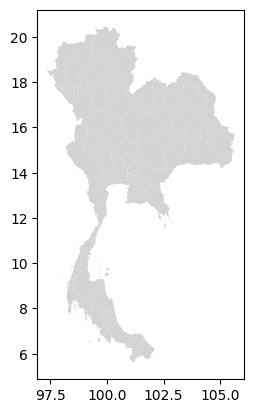

In [16]:
thailand = gpd.read_file('thai.shp')
thailand.plot(ax=plt.gca(), color='lightgrey')


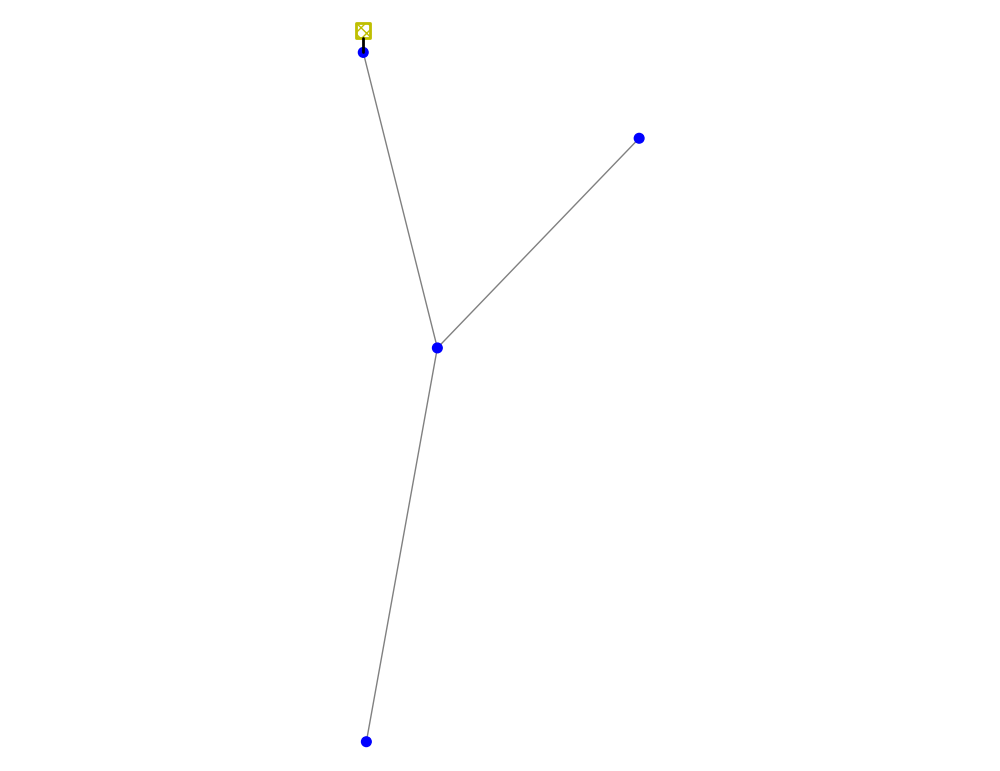

<Axes: >

In [17]:
pp.plotting.simple_plot(net)

In [18]:
# Run the network using the NR algorithm
pp.runpp(net,algorithm='nr', max_iteration=10000);


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



In [19]:
net.line

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,None,None,0,2,500.0,0.01,0.01,1.000000e-09,0.0,30.0,1.0,1,None,True
1,None,None,2,1,500.0,0.01,0.01,1.000000e-09,0.0,20.0,1.0,1,None,True
2,None,None,2,3,400.0,0.01,0.01,1.000000e-09,0.0,20.0,1.0,1,None,True


use_bus_geodata is automatically set to True, since net.line_geodata is empty.


<Axes: >

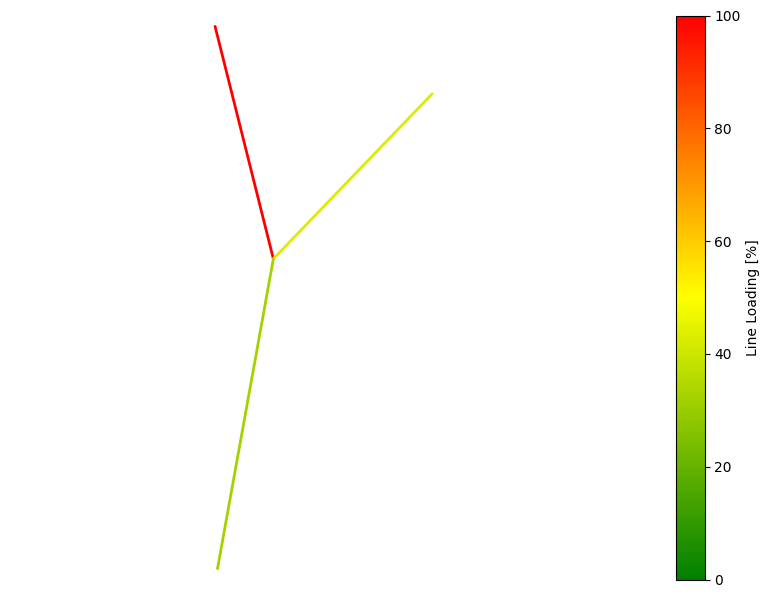

In [20]:
cmap_list=[(0, "green"), (50, "yellow"), (100, "red")]
cmap, norm = plot.cmap_continuous(cmap_list)

lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=2)
plot.draw_collections([lc], figsize=(8,6))

<Axes: >

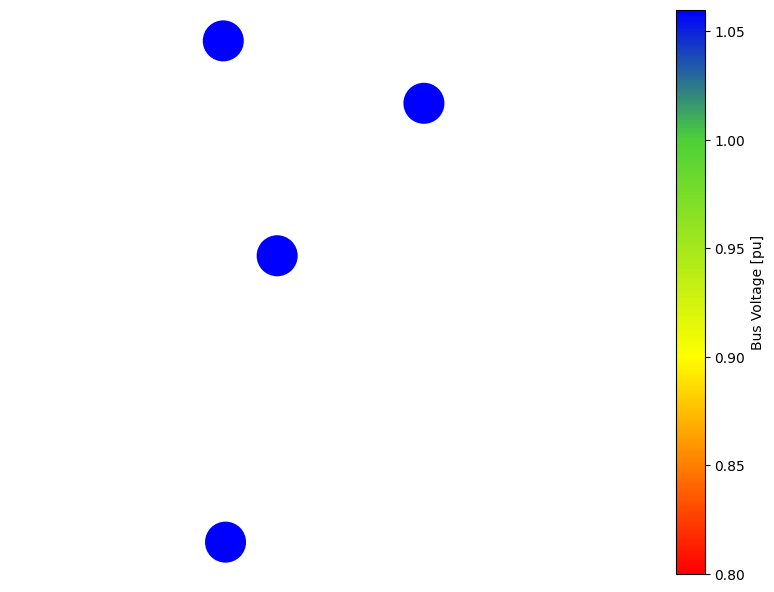

In [21]:
ideal_color = "#4cd137"
too_high_color = "blue"
too_low_color = "yellow"
very_low_color = "red"
cmap_list=[(0.8, very_low_color), (0.9, too_low_color), (1.0, ideal_color), (1.06, too_high_color)] #+6 and -10 percent for voltage regulations
cmap, norm = plot.cmap_continuous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=0.4, zorder=2, cmap=cmap, norm=norm)
plot.draw_collections([bc], figsize=(8,6))

<Axes: >

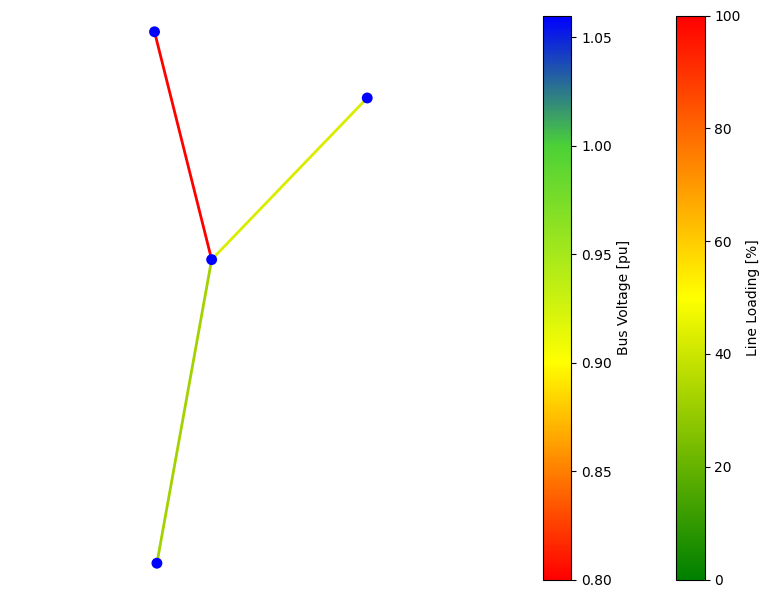

In [22]:
ideal_color = "#4cd137"
too_high_color = "blue"
too_low_color = "red"
cmap_list=[(0.8,"red"),(0.9, "yellow"), (1.0, ideal_color), (1.06, too_high_color)] #+6 and -10 percent for voltage regulations
cmap, norm = plot.cmap_continuous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=cmap, norm=norm)
plot.draw_collections([lc,bc], figsize=(8,6))

2 in collections is of unknown type. Skipping


<Axes: >

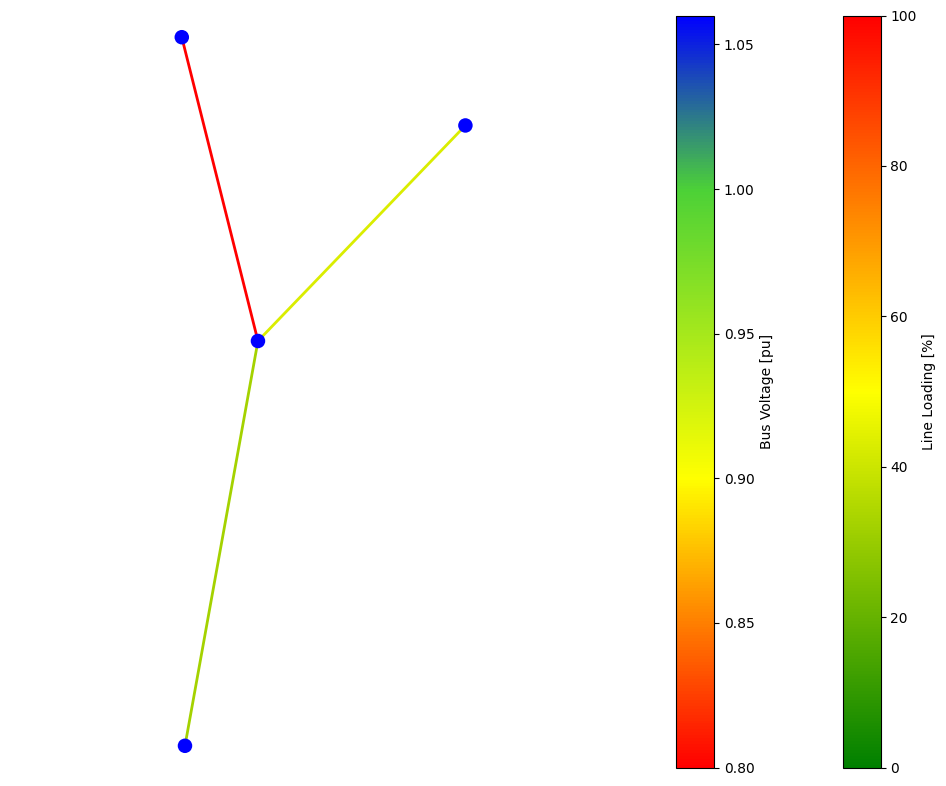

In [23]:
cmap_list=[(50, "green"), (75, "yellow"), (100, "red")]
cmap, norm = plot.cmap_continuous(cmap_list)
tc = pp.plotting.create_trafo_collection(net, net.trafo.index, cmap=cmap, norm=norm)
plot.draw_collections([lc,bc, tc])

In [24]:
# Print the elements of the network
net

This pandapower network includes the following parameter tables:
   - bus (4 element)
   - load (4 element)
   - sgen (4 element)
   - ext_grid (1 elements)
   - line (3 element)
   - bus_geodata (4 element)
 and the following results tables:
   - res_bus (4 element)
   - res_line (3 element)
   - res_ext_grid (1 elements)
   - res_load (4 element)
   - res_sgen (4 element)

In [25]:
# Display line results
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,-27209.802545,17844.997595,44710.914838,-343.885302,17501.112292,17501.112292,34.157588,34.157588,34.157588,1.100000,0.000000,1.511501,32.817383,113.858627
1,-5144.252988,235.047072,5376.400060,-2.900000,232.147072,232.147072,3.934015,8.552206,8.552206,1.511501,32.817383,1.578066,35.402571,42.761029
2,-3865.761820,106.938230,3970.500050,-2.200000,104.738230,104.738230,2.954350,6.422501,6.422501,1.511501,32.817383,1.551860,34.370200,32.112504


In [26]:
# Display bus results
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.100000,0.000000,27209.802545,-17844.997595
1,1.578066,35.402571,-5376.400060,2.900000
2,1.511501,32.817383,-35700.900030,1.900000
3,1.551860,34.370200,-3970.500050,2.200000


In [27]:
# Display generator results
net.res_gen

,p_mw,q_mvar,va_degree,vm_pu


In [28]:
#Display transformer results
net.res_trafo

,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,pl_mw,ql_mvar,i_hv_ka,i_lv_ka,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree,loading_percent


use_bus_geodata is automatically set to True, since net.line_geodata is empty.


<Axes: >

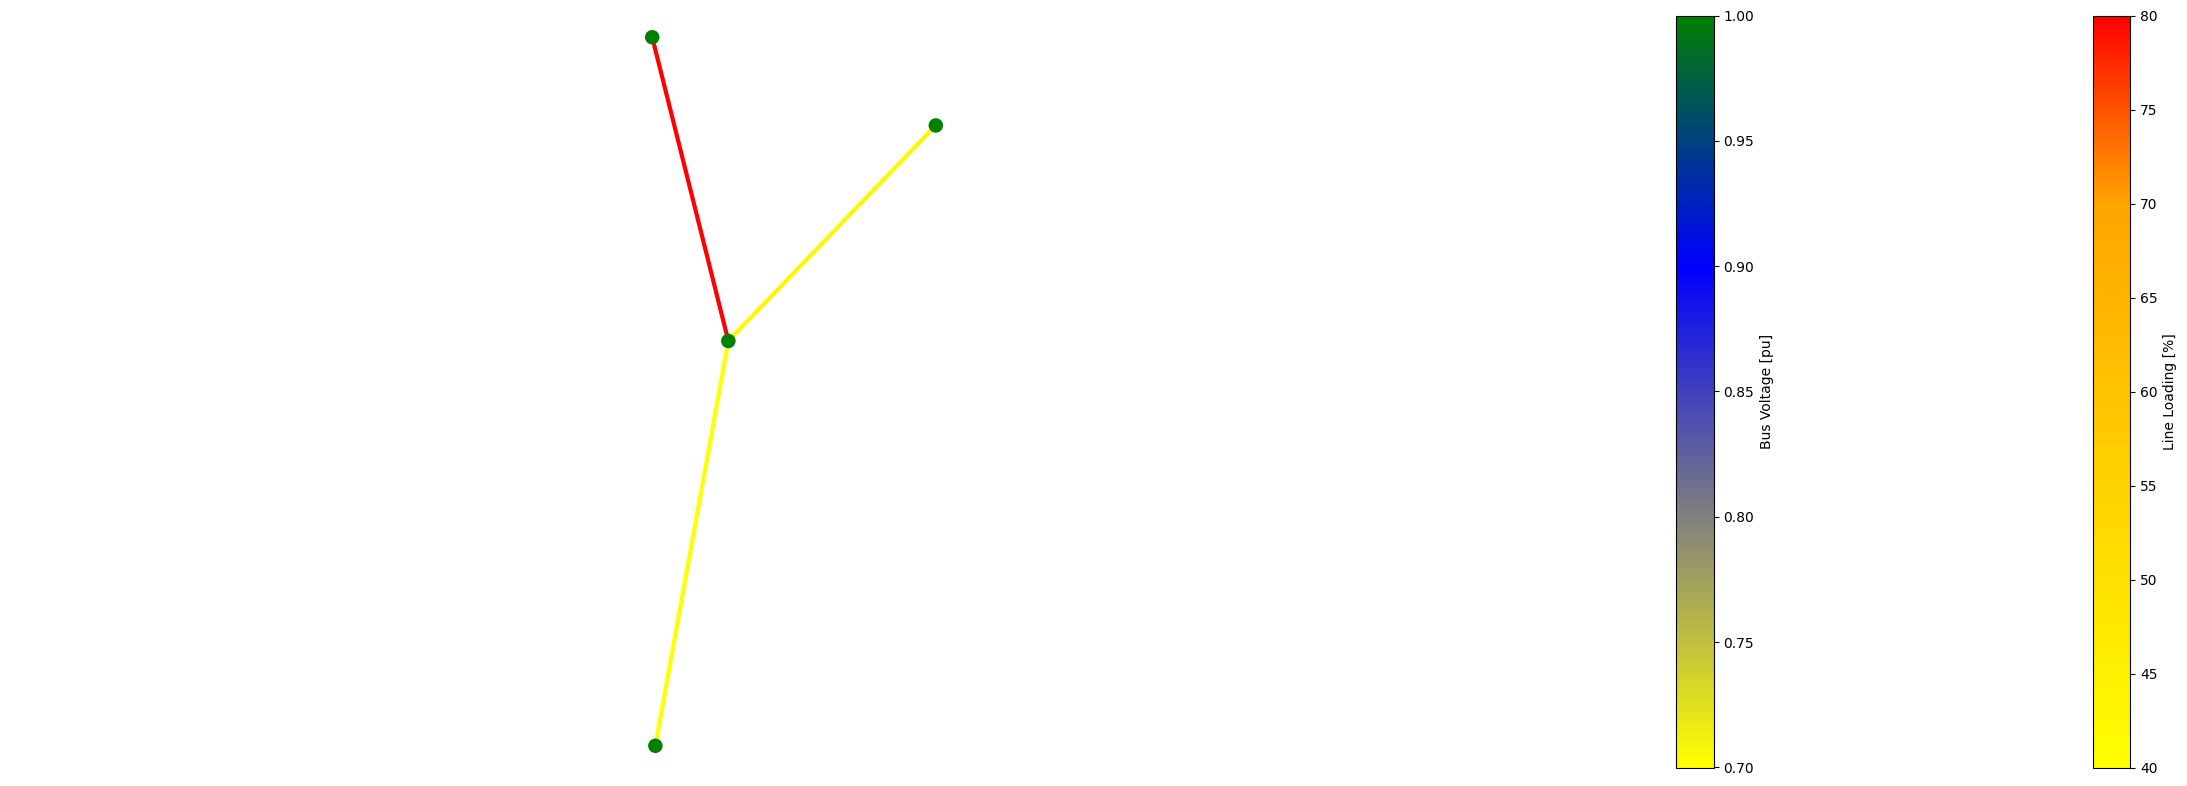

In [29]:
# Plot an advanced visual of the network showing the line loading results and voltage drops

import pandapower.plotting as plot
import matplotlib.pyplot as plt
import seaborn

# Creating the line color collection
cmap_list=[(40, "yellow"), (70, "orange"), (80, "red")]
cmap, norm = plot.cmap_continuous(cmap_list)
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=3)

# Creating the bus color collection
cmap_list=[(0.7, "yellow"), (0.9, "blue"), (1.0, "green")]
cmap, norm = plot.cmap_continuous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=cmap, norm=norm)

plot.draw_collections([lc, bc], figsize=(25,8))

In [30]:
#Print results to an excel file
#pp.to_excel(net, "results.xlsx") 